## COMPUTER VISION MINI-PROJECT
## NEURAL STYLE TRANSFER
## Saransh Bhatnagar (I007), Aditya Patankar (I037),Viraj Patil (I038)

## Part 2

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

In [ ]:
vgg = models.vgg19(weights='VGG19_Weights.DEFAULT').features


for param in vgg.parameters():
    param.requires_grad_(False)
vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 48.0MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Object Detection

In [ ]:

rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
rcnn_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 85.2MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

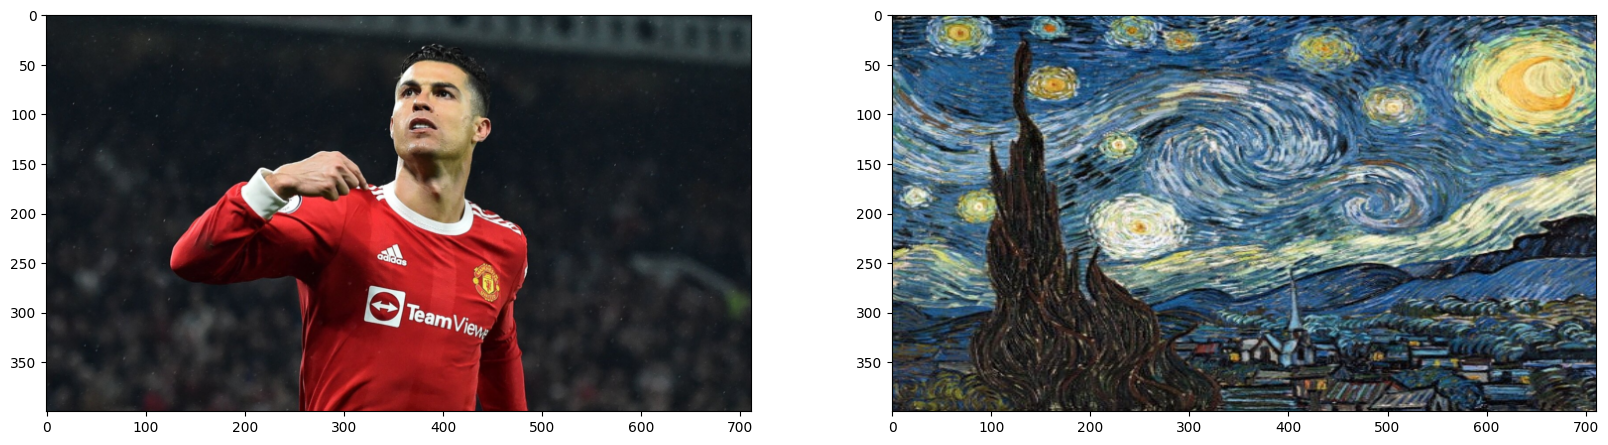

In [ ]:
def load_image(img_path, max_size=400, shape=None):

    image = Image.open(img_path).convert('RGB')


    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])


    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

content = load_image('/content/content.png')

style = load_image('/content/style1.png', shape=content.shape[-2:])


def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [ ]:
def detect_objects(image):
    with torch.no_grad():
        predictions = rcnn_model(image)
    return predictions

In [ ]:
content_objects = detect_objects(content)

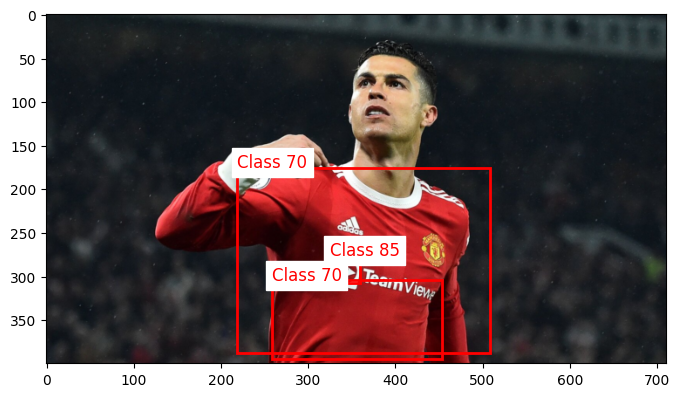

In [ ]:
boxes = content_objects[0]['boxes']
labels = content_objects[0]['labels']

plt.figure(figsize=(8, 8))
plt.imshow(im_convert(content))

for i in range(len(boxes)):
    box = boxes[i].cpu().numpy()
    label = labels[i].cpu().numpy()
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='r', linewidth=2))
    plt.text(box[0], box[1], f'Class {label}', fontsize=12, color='r', backgroundcolor='w')
plt.show()

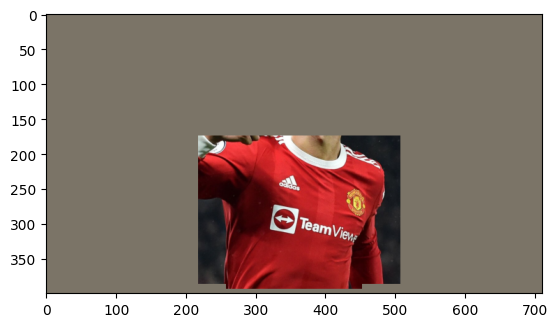

In [ ]:
object_mask = torch.zeros_like(content)
for box in boxes:
    x1, y1, x2, y2 = map(int, box.tolist())
    object_mask[:, :, y1:y2, x1:x2] = content[:, :, y1:y2, x1:x2]

plt.imshow(im_convert(object_mask))
plt.show()

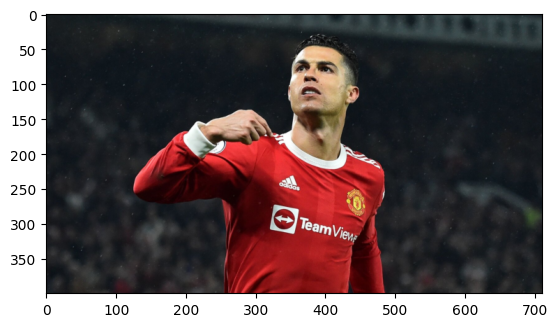

In [ ]:
plt.imshow(im_convert(content))
plt.show()

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [ ]:
def gram_matrix(tensor):


    gram = None
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram


content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


target = content.clone().requires_grad_(True)

In [ ]:
style_weights = {'conv1_1': 1.,
'conv2_1': 0.8,
'conv3_1': 0.5,
'conv4_1': 0.3,
'conv5_1': 0.1}

content_weight = 1
style_weight = 1e6

Total loss:  1731624.5


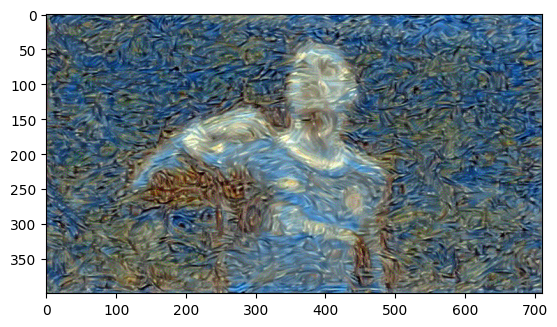

Total loss:  712409.25


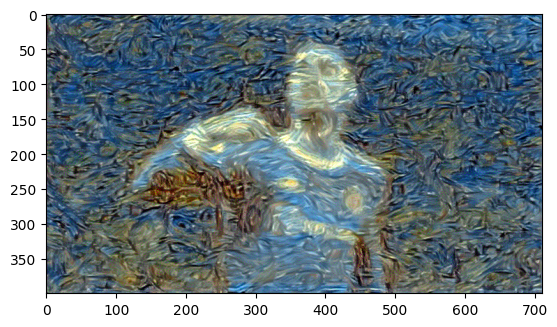

Total loss:  390742.5


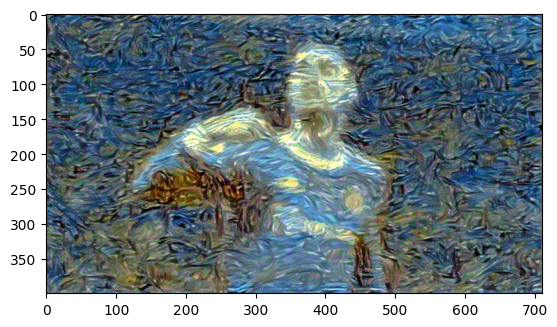

Total loss:  244118.1875


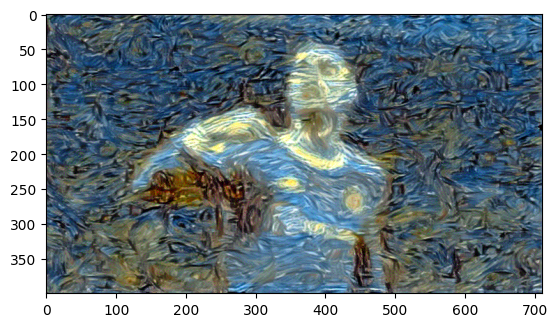

Total loss:  166963.953125


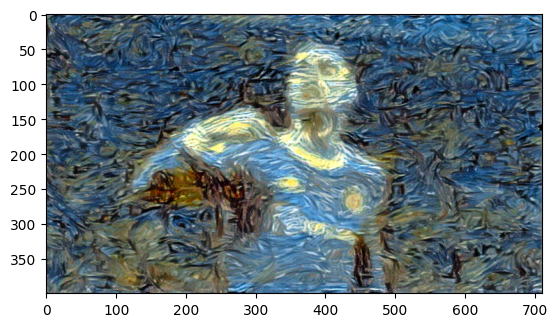

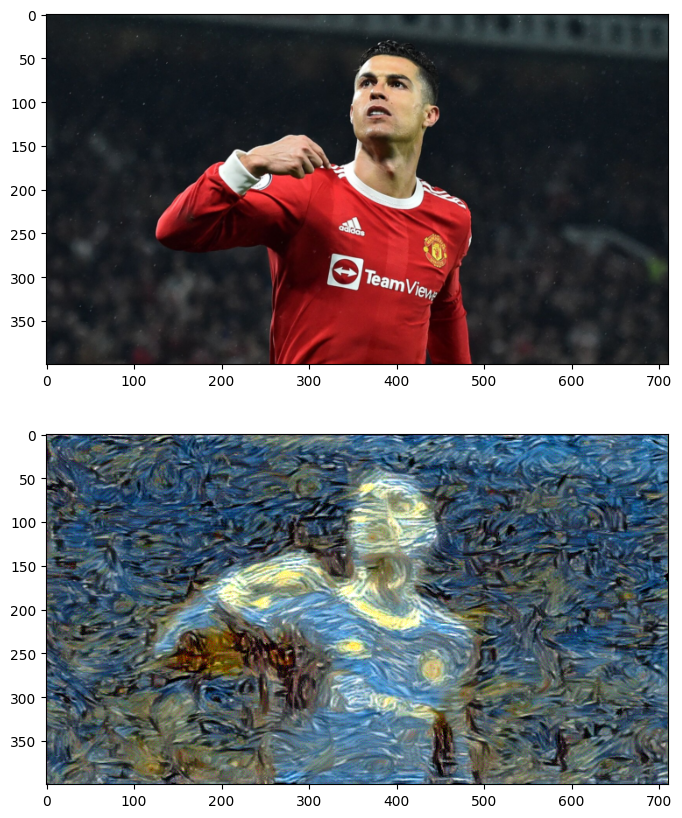

In [ ]:

show_every = 400

optimizer = optim.Adam([target], lr=0.9)
steps = 2000

for ii in range(1, steps+1):


    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)


        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss


    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))


## Image Segmentation

In [ ]:
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

In [ ]:

mask_rcnn_model = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 138MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
from PIL import Image
image_path = "/content/content.png"
content_seg = Image.open(image_path)

In [ ]:
def segment_objects(image):
    transform = T.Compose([T.Resize(800), T.ToTensor()])
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        prediction = mask_rcnn_model(input_image)
    return prediction[0]


segmentation_result = segment_objects(content_seg)

In [ ]:

masks = segmentation_result['masks']
object_masks = masks.squeeze(1).cpu().numpy()

In [ ]:

object_mask = torch.tensor(object_masks.max(axis=0)).unsqueeze(0).unsqueeze(0)
object_mask_resized = torch.nn.functional.interpolate(object_mask, size=(content.shape[-2], content.shape[-1]), mode='nearest')


In [ ]:

background_mask = 1 - object_mask_resized


background = content * background_mask

In [ ]:
def gram_matrix(tensor):


    gram = None
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

content_features = get_features(background, vgg)
style_features = get_features(style, vgg)


style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = background.clone().requires_grad_(True)

In [ ]:
style_weights = {'conv1_1': 1.,
'conv2_1': 0.8,
'conv3_1': 0.5,
'conv4_1': 0.3,
'conv5_1': 0.1}

content_weight = 1
style_weight = 1e6

Total loss:  1716174.875


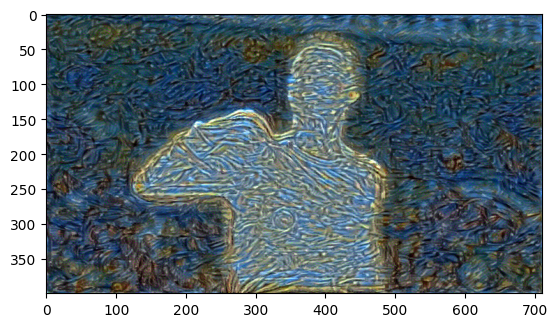

Total loss:  534161.6875


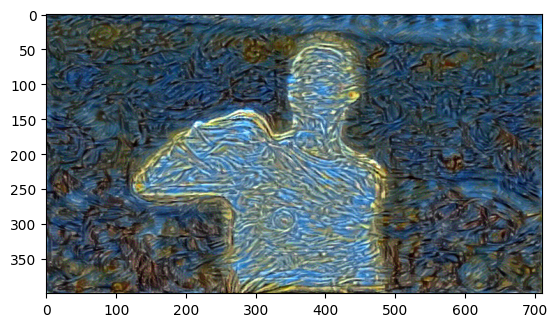

Total loss:  328568.15625


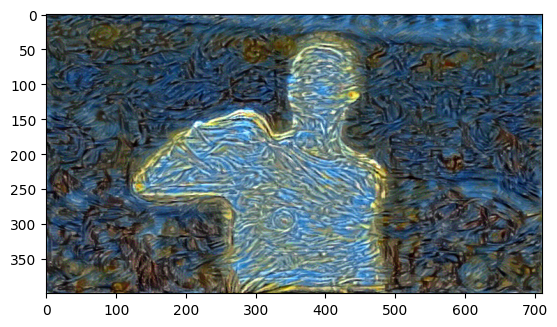

Total loss:  241520.171875


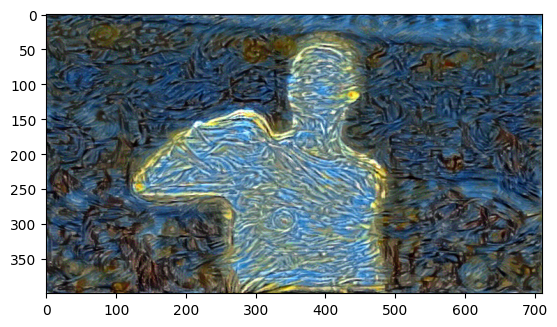

Total loss:  280784.875


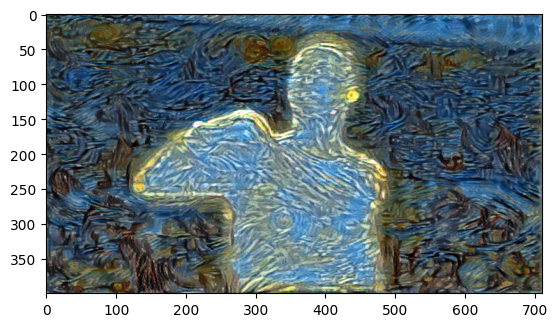

In [ ]:

show_every = 200


optimizer = optim.Adam([target], lr=0.3)
steps = 1000

for ii in range(1, steps+1):


    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)

    style_loss = 0

    for layer in style_weights:

        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)


        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss


    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
def paste_object(object_region, target):
    assert object_region.shape == target.shape, "Tensor shapes must match"

    stylized_background = target * (1 - object_mask_resized)


    final_image = object_region + stylized_background

    return final_image

object_region = content * object_mask_resized
final_image = paste_object(object_region, target)

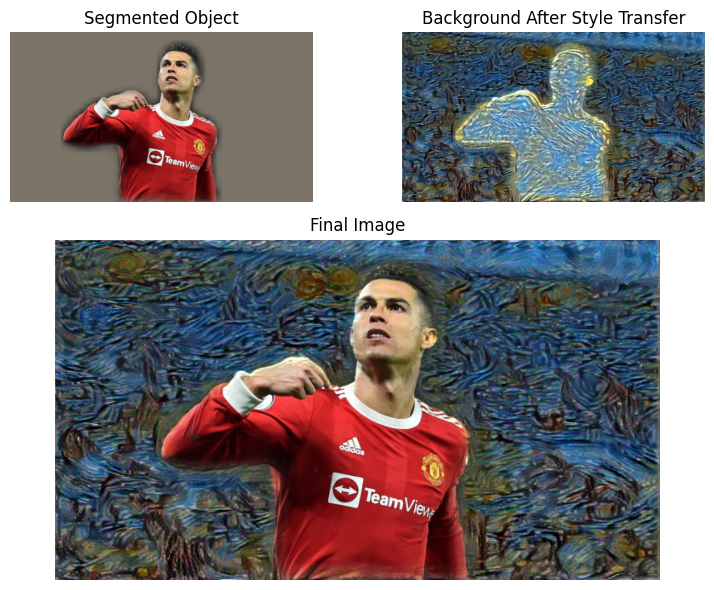

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])

ax1 = plt.subplot(gs[0, 0])
ax1.imshow(im_convert(object_region))
ax1.set_title('Segmented Object')
ax1.axis('off')

ax2 = plt.subplot(gs[0, 1])
ax2.imshow(im_convert(target))
ax2.set_title('Background After Style Transfer')
ax2.axis('off')

ax3 = plt.subplot(gs[1, :])
ax3.imshow(im_convert(final_image))
ax3.set_title('Final Image')
ax3.axis('off')

plt.tight_layout()
plt.show()